In [ ]:
#creating the model

import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import os
import joblib

# ----------------------------
# CONFIG
# ----------------------------
FEATURES_BASE = [
    "day_of_week",
    "is_weekend",
    "day_of_year",
    "qty_lag_1",
    "qty_lag_7",
    "qty_lag_14",
    "qty_roll_7",
    "qty_roll_14",
    "is_holiday",
    "days_to_holiday",
    "days_since_holiday",
    "is_fasting",
]

TARGET = "target_qty"
MIN_HISTORY_DAYS = 90

DATA_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/"
MODEL_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/models/"
os.makedirs(MODEL_PATH, exist_ok=True)

# ----------------------------
# LOAD DATA
# ----------------------------
train_df = pd.read_csv(DATA_PATH + "train_data.csv", parse_dates=["date"])
test_df  = pd.read_csv(DATA_PATH + "test_data.csv",  parse_dates=["date"])

train_df = train_df.sort_values(["sku_id", "date"])
test_df  = test_df.sort_values(["sku_id", "date"])

# ----------------------------
# FILTER SKUs WITH TOO LITTLE DATA
# ----------------------------
valid_skus = (
    train_df.groupby("sku_id")
    .size()
    .loc[lambda x: x >= MIN_HISTORY_DAYS]
    .index
)

train_df = train_df[train_df["sku_id"].isin(valid_skus)]
test_df  = test_df[test_df["sku_id"].isin(valid_skus)]

# ----------------------------
# CATEGORY TARGET ENCODING (TRAIN ONLY)
# ----------------------------
category_mean = (
    train_df
    .groupby("category")[TARGET]
    .mean()
)

train_df["category_te"] = train_df["category"].map(category_mean)
test_df["category_te"]  = test_df["category"].map(category_mean)

global_mean = train_df[TARGET].mean()
test_df["category_te"] = test_df["category_te"].fillna(global_mean)

# ----------------------------
# SKU BEHAVIOR FEATURES (ROLLING)
# ----------------------------
def add_sku_behavior(df):
    df = df.copy()
    df["sku_avg_28d"] = (
        df.groupby("sku_id")["daily_qty"]
        .rolling(28)
        .mean()
        .reset_index(level=0, drop=True)
    )
    df["sku_std_28d"] = (
        df.groupby("sku_id")["daily_qty"]
        .rolling(28)
        .std()
        .reset_index(level=0, drop=True)
    )
    return df

train_df = add_sku_behavior(train_df)
test_df  = add_sku_behavior(test_df)

# ----------------------------
# FINAL FEATURE LIST
# ----------------------------
FEATURES = FEATURES_BASE + [
    "category_te",
    "sku_avg_28d",
    "sku_std_28d",
]

# ----------------------------
# DROP NA (ONLY AFTER FEATURES READY)
# ----------------------------
train_df = train_df.dropna(subset=FEATURES + [TARGET])
test_df  = test_df.dropna(subset=FEATURES + [TARGET])

# ----------------------------
# TRAIN GLOBAL MODEL
# ----------------------------
model = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.05,
    max_iter=300,
    random_state=42
)

model.fit(train_df[FEATURES], train_df[TARGET])

joblib.dump(model, MODEL_PATH + "global_demand_model.joblib")

# ----------------------------
# EVALUATION
# ----------------------------
test_df["pred"] = model.predict(test_df[FEATURES]).clip(0)

overall_mae = mean_absolute_error(test_df[TARGET], test_df["pred"])

sku_mae = (
    test_df
    .groupby("sku_id")
    .apply(lambda x: mean_absolute_error(x[TARGET], x["pred"]))
    .reset_index(name="sku_mae")
)

print(f"Global MAE: {overall_mae:.2f}")
print("Sample SKU MAE:")
print(sku_mae.head())

sku_mae.to_csv(DATA_PATH + "global_model_sku_mae.csv", index=False)

print("Global model training & evaluation complete.")


Global MAE: 2.04
Sample SKU MAE:
       sku_id   sku_mae
0  555-HOU001  1.746907
1  ABC-BAB001  2.431044
2  ABC-BAB002  2.597725
3  ABC-BAB003  2.452981
4  ABC-BAB004  2.407970
Global model training & evaluation complete.


/tmp/ipython-input-2190843274.py:133: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: mean_absolute_error(x[TARGET], x["pred"]))


In [ ]:
# Loading data for evaluation
import pandas as pd
import numpy as np
import joblib

MODEL_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/models/global_demand_model.joblib"
DATA_PATH  = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/"

# ----------------------------
# CONFIG (Copied from Mv_jgUlwXkQp to ensure consistency)
# ----------------------------
FEATURES_BASE = [
    "day_of_week",
    "is_weekend",
    "day_of_year",
    "qty_lag_1",
    "qty_lag_7",
    "qty_lag_14",
    "qty_roll_7",
    "qty_roll_14",
    "is_holiday",
    "days_to_holiday",
    "days_since_holiday",
    "is_fasting",
]

TARGET = "target_qty"
MIN_HISTORY_DAYS = 90

# ----------------------------
# LOAD DATA
# ----------------------------
# Load both train and test data, as train_df is needed for category_te
train_df = pd.read_csv(DATA_PATH + "train_data.csv", parse_dates=["date"])
test_df  = pd.read_csv(DATA_PATH + "test_data.csv",  parse_dates=["date"])

train_df = train_df.sort_values(["sku_id", "date"])
test_df  = test_df.sort_values(["sku_id", "date"])

# ----------------------------
# FILTER SKUs WITH TOO LITTLE DATA (Consistent with training)
# ----------------------------
valid_skus = (
    train_df.groupby("sku_id")
    .size()
    .loc[lambda x: x >= MIN_HISTORY_DAYS]
    .index
)

train_df = train_df[train_df["sku_id"].isin(valid_skus)]
test_df  = test_df[test_df["sku_id"].isin(valid_skus)]

# ----------------------------
# CATEGORY TARGET ENCODING (Consistent with training)
# ----------------------------
category_mean = (
    train_df
    .groupby("category")[TARGET]
    .mean()
)

test_df["category_te"]  = test_df["category"].map(category_mean)

global_mean = train_df[TARGET].mean() # Use global mean from training data
test_df["category_te"] = test_df["category_te"].fillna(global_mean)

# ----------------------------
# SKU BEHAVIOR FEATURES (ROLLING) (Consistent with training)
# ----------------------------
def add_sku_behavior(df):
    df = df.copy()
    df["sku_avg_28d"] = (
        df.groupby("sku_id")["daily_qty"]
        .rolling(28)
        .mean()
        .reset_index(level=0, drop=True)
    )
    df["sku_std_28d"] = (
        df.groupby("sku_id")["daily_qty"]
        .rolling(28)
        .std()
        .reset_index(level=0, drop=True)
    )
    return df

test_df  = add_sku_behavior(test_df)

# ----------------------------
# FINAL FEATURE LIST (Must match training features)
# ----------------------------
FEATURES = FEATURES_BASE + [
    "category_te",
    "sku_avg_28d",
    "sku_std_28d",
]

# ----------------------------
# DROP NA (ONLY AFTER FEATURES READY) (Consistent with training)
# ----------------------------
test_df  = test_df.dropna(subset=FEATURES + [TARGET])

model = joblib.load(MODEL_PATH)

test_df["daily_pred"] = model.predict(test_df[FEATURES]).clip(0)
test_df["year_month"] = test_df["date"].dt.to_period("M")

monthly_preds = (
    test_df
    .groupby(["sku_id", "year_month"])["daily_pred"]
    .sum()
    .reset_index()
    .rename(columns={"daily_pred": "predicted_monthly_qty"})
)

# Comparing with actual pridiction
actual_monthly = (
    test_df
    .groupby(["sku_id", "year_month"])["target_qty"]
    .sum()
    .reset_index()
    .rename(columns={"target_qty": "actual_monthly_qty"})
)

monthly_results = monthly_preds.merge(
    actual_monthly,
    on=["sku_id", "year_month"],
    how="left"
)

monthly_results["abs_error"] = (
    monthly_results["predicted_monthly_qty"]
    - monthly_results["actual_monthly_qty"]
).abs()

monthly_results["pct_error"] = np.where(
    monthly_results["actual_monthly_qty"] > 0,
    monthly_results["abs_error"] / monthly_results["actual_monthly_qty"] * 100,
    0
)
monthly_results.to_csv(
    DATA_PATH + "global_monthly_predictions_per_sku.csv",
    index=False
)

print("Monthly per-SKU predictions generated.")
print(monthly_results.head())

Monthly per-SKU predictions generated.
       sku_id year_month  predicted_monthly_qty  actual_monthly_qty  \
0  555-HOU001    2023-10              75.746101                86.0   
1  555-HOU001    2023-11             100.502837                94.0   
2  555-HOU001    2023-12              54.139470                55.0   
3  555-HOU001    2024-01             114.560146               115.0   
4  555-HOU001    2024-02              93.418651               106.0   

   abs_error  pct_error  
0  10.253899  11.923138  
1   6.502837   6.917912  
2   0.860530   1.564599  
3   0.439854   0.382482  
4  12.581349  11.869197  


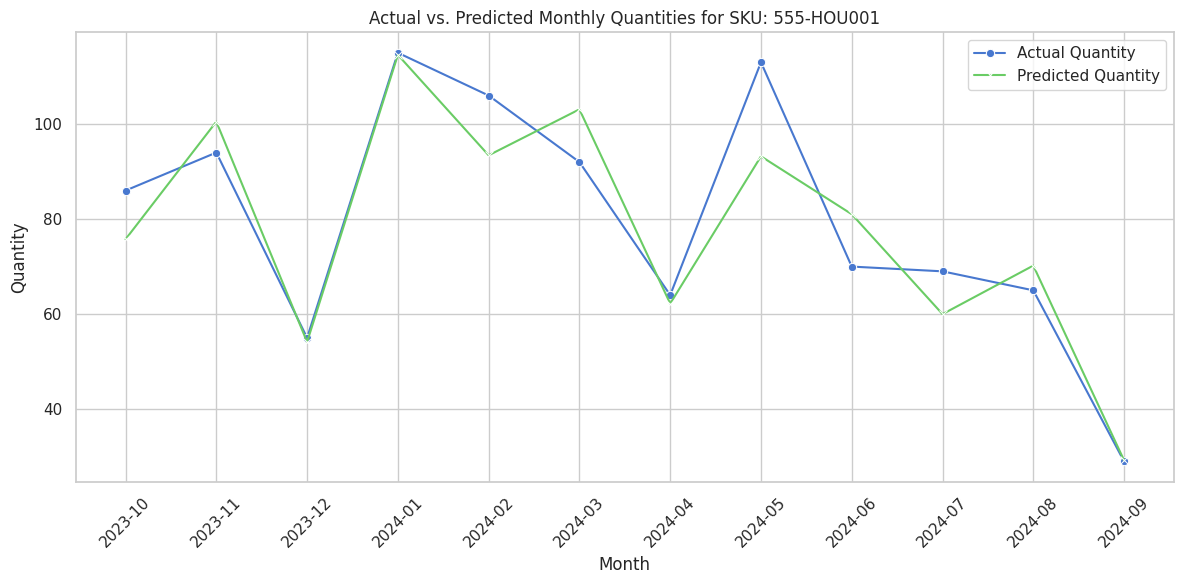

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Select a sample SKU, e.g., the first one in the results
sample_sku = monthly_results['sku_id'].iloc[0]
sample_sku_results = monthly_results[monthly_results['sku_id'] == sample_sku].sort_values('year_month')

plt.figure(figsize=(12, 6))
sns.lineplot(x=sample_sku_results['year_month'].astype(str), y='actual_monthly_qty', data=sample_sku_results, label='Actual Quantity', marker='o')
sns.lineplot(x=sample_sku_results['year_month'].astype(str), y='predicted_monthly_qty', data=sample_sku_results, label='Predicted Quantity', marker='x')

plt.title(f'Actual vs. Predicted Monthly Quantities for SKU: {sample_sku}')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Overall Mean Absolute Error: 17.26
Overall Mean Absolute Percentage Error: 15.47%


/tmp/ipython-input-2674260873.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right') # Rotate and align labels


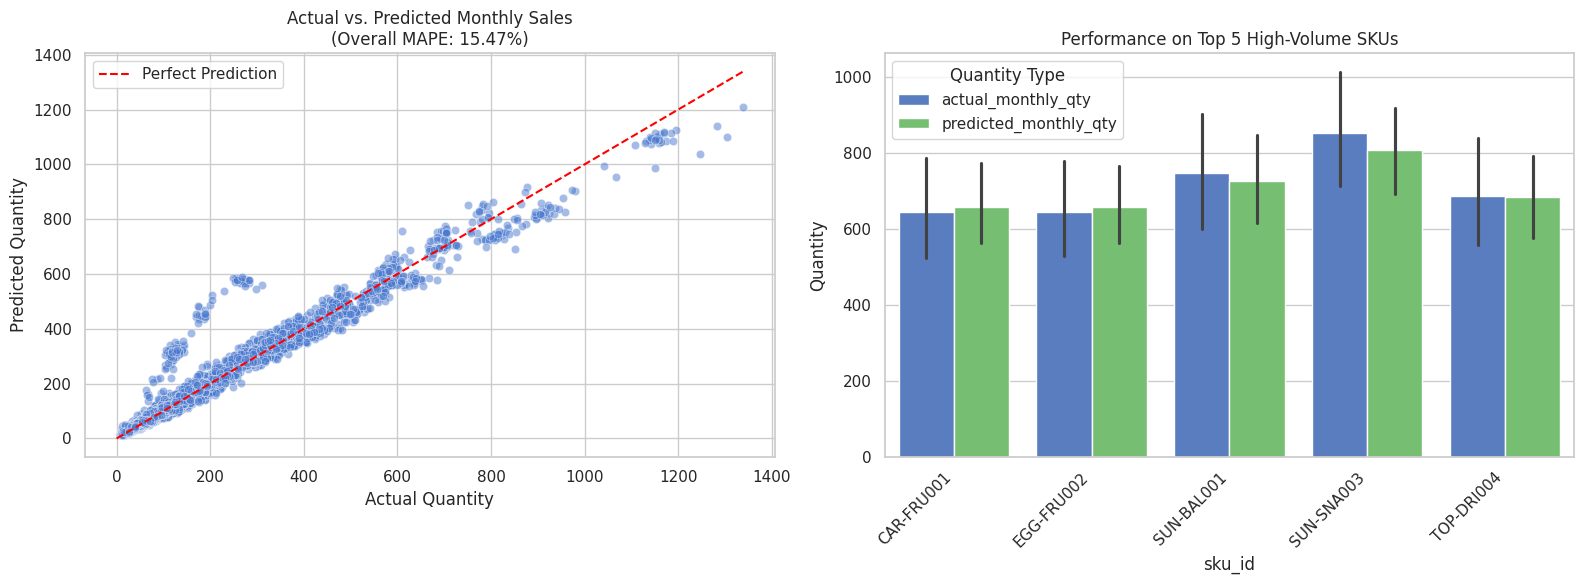

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results generated from code cell 2 (or ensure monthly_results is in scope)
# For robustness, we'll load it from the saved CSV.
# If you ran code cell 2, `monthly_results` should already be available.
try:
    monthly_results = pd.read_csv("/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/global_monthly_predictions_per_sku.csv")
    monthly_results['year_month'] = pd.PeriodIndex(monthly_results['year_month'], freq='M')
except NameError:
    print("monthly_results DataFrame not found. Please run code cell 2 first.")
    exit()

# Calculate Global Metrics for context on the scatter plot
overall_mae = monthly_results['abs_error'].mean()
overall_mape = monthly_results['pct_error'].mean()

print(f"Overall Mean Absolute Error: {overall_mae:.2f}")
print(f"Overall Mean Absolute Percentage Error: {overall_mape:.2f}%")

# Plotting Setup
plt.style.use('seaborn-v0_8-muted')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- PLOT 1: Scatter Plot (Actual vs Predicted) ---
sns.scatterplot(data=monthly_results, x='actual_monthly_qty', y='predicted_monthly_qty', alpha=0.5, ax=ax1)
# Add a 45-degree line (Perfect prediction line)
max_val = max(monthly_results['actual_monthly_qty'].max(), monthly_results['predicted_monthly_qty'].max())
ax1.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Prediction')

ax1.set_title(f"Actual vs. Predicted Monthly Sales\n(Overall MAPE: {overall_mape:.2f}%)")
ax1.set_xlabel("Actual Quantity")
ax1.set_ylabel("Predicted Quantity")
ax1.legend()

# --- PLOT 2: Top 5 SKUs Comparison ---
# Get the top 5 SKUs by total actual volume to keep the chart readable
top_skus = monthly_results.groupby('sku_id')['actual_monthly_qty'].sum().nlargest(5).index
top_df = monthly_results[monthly_results['sku_id'].isin(top_skus)]

# Melt the data for easier plotting with Seaborn
melted_df = top_df.melt(id_vars=['sku_id', 'year_month'],
                        value_vars=['actual_monthly_qty', 'predicted_monthly_qty'],
                        var_name='Type', value_name='Quantity')

sns.barplot(data=melted_df, x='sku_id', y='Quantity', hue='Type', ax=ax2)
ax2.set_title("Performance on Top 5 High-Volume SKUs")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right') # Rotate and align labels
ax2.legend(title='Quantity Type')

plt.tight_layout()
plt.savefig("forecasting_performance.png")
plt.show()

/tmp/ipython-input-1731733982.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


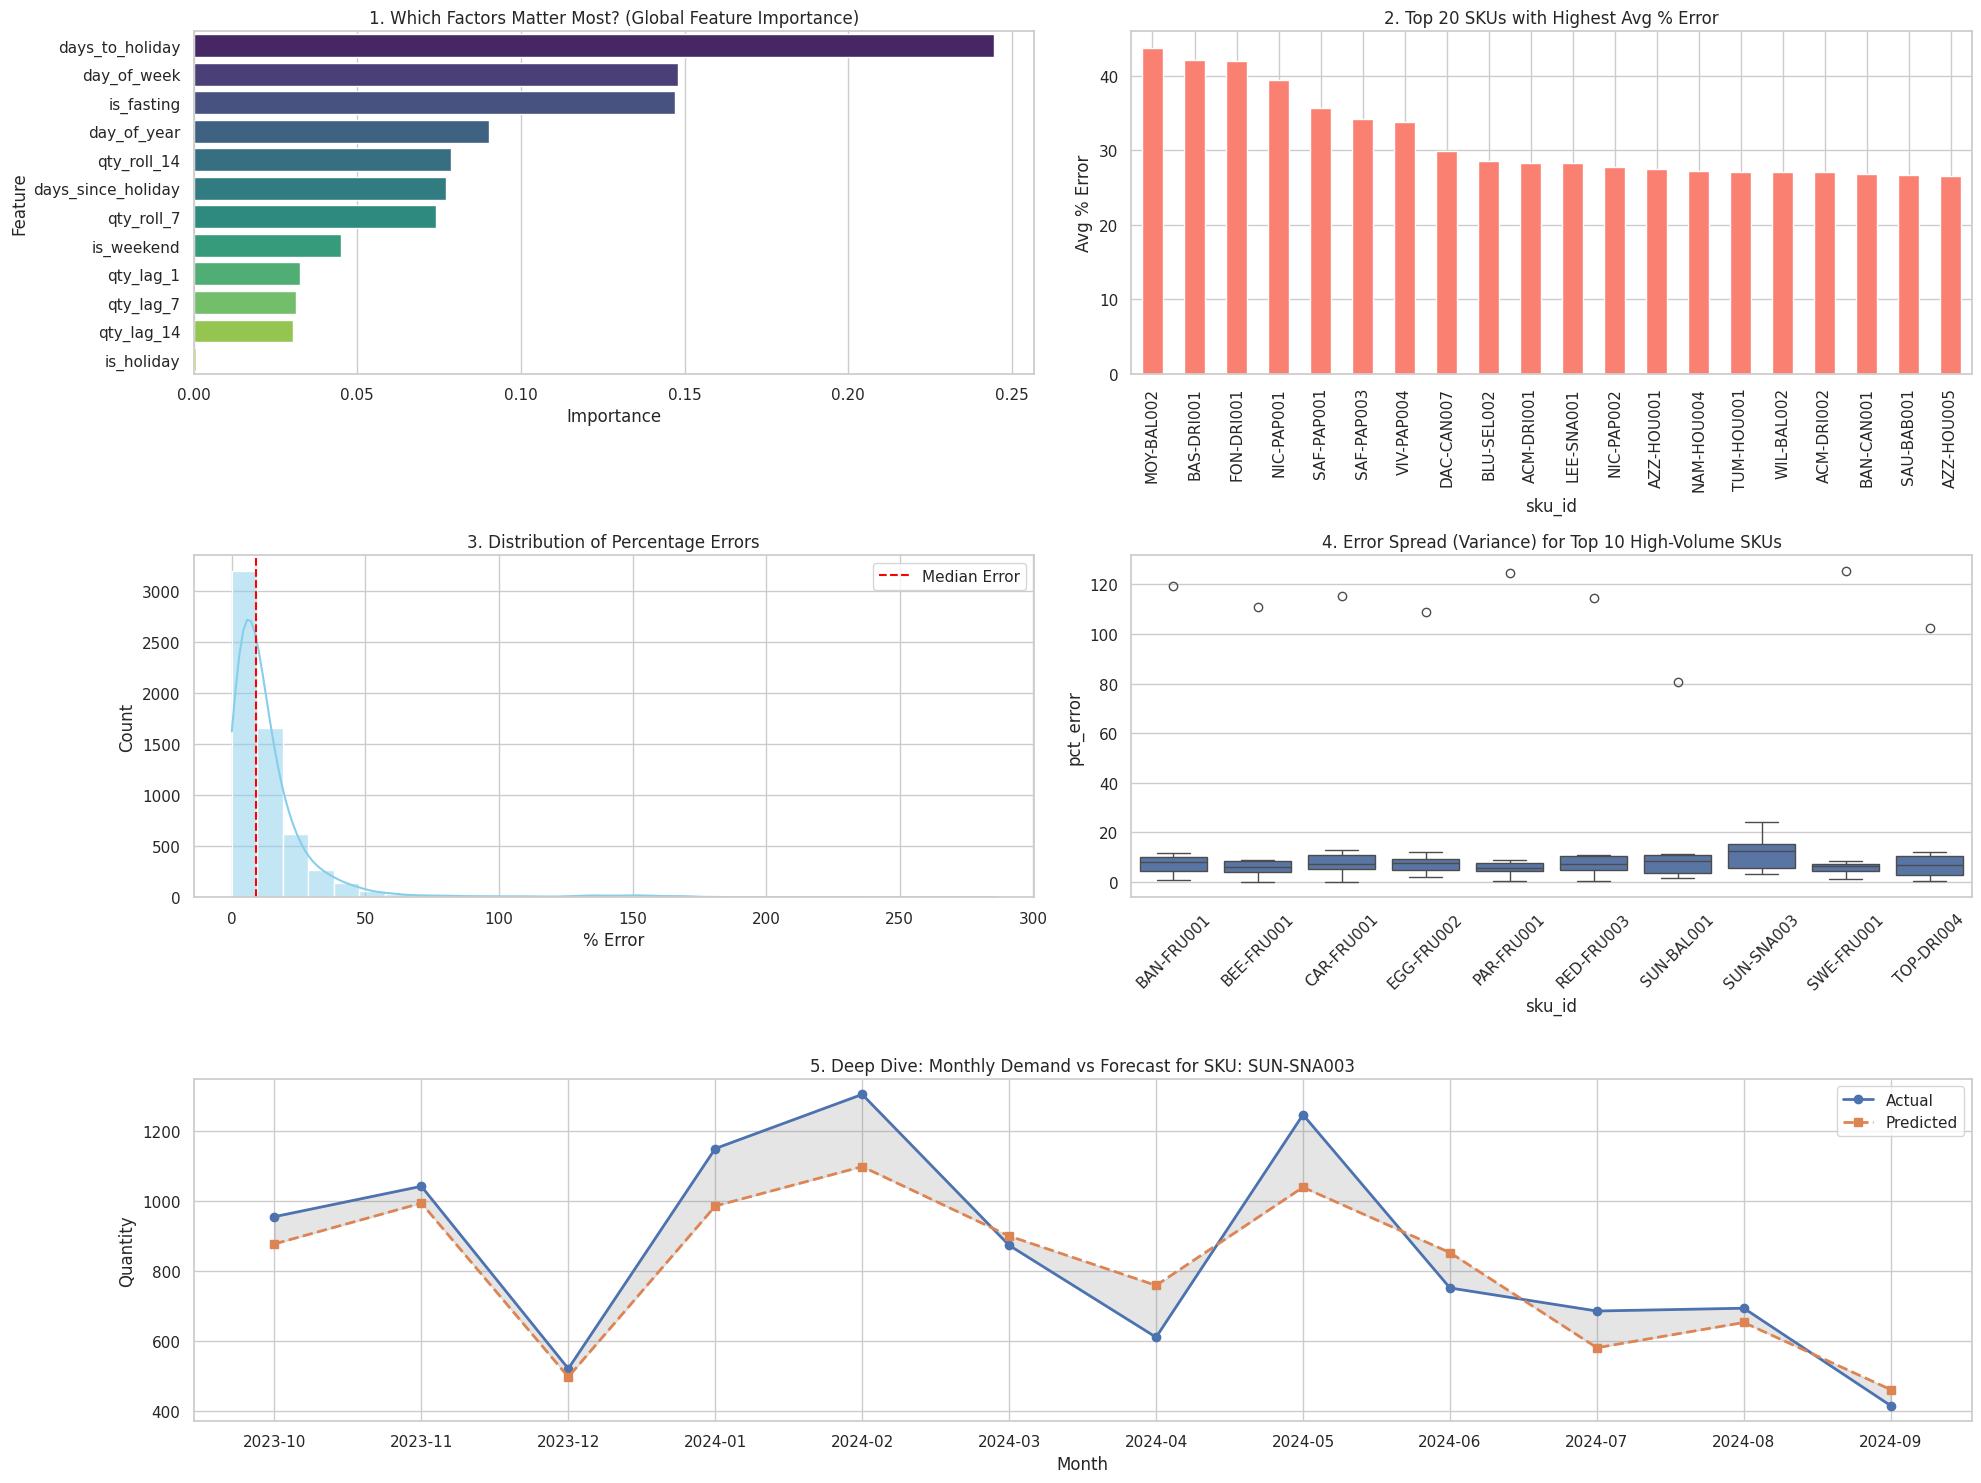

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(20, 15))

# Load the results and feature importance (assuming they are saved)
results_df = pd.read_csv("/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/global_monthly_predictions_per_sku.csv")
results_df['year_month'] = pd.PeriodIndex(results_df['year_month'], freq='M')

# NOTE: importance_df is assumed to be available from a previously run cell (like iiQ6cKmvEp3s)
# If running this cell independently after a kernel restart, you might need to re-generate it.
# For this demonstration, we'll use the existing 'importance_df' variable from the kernel state.

# 1. Feature Importance (Average across all SKU models)
plt.subplot(3, 2, 1)
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("1. Which Factors Matter Most? (Global Feature Importance)")

# 2. Average Percentage Error per SKU
# (Showing top 20 most 'problematic' SKUs to keep it readable)
plt.subplot(3, 2, 2)
sku_error = results_df.groupby('sku_id')['pct_error'].mean().sort_values(ascending=False).head(20)
sku_error.plot(kind='bar', color='salmon')
plt.title("2. Top 20 SKUs with Highest Avg % Error")
plt.ylabel("Avg % Error")

# 3. Error Distribution
plt.subplot(3, 2, 3)
sns.histplot(results_df['pct_error'], kde=True, color='skyblue', bins=30)
plt.axvline(results_df['pct_error'].median(), color='red', linestyle='--', label='Median Error')
plt.title("3. Distribution of Percentage Errors")
plt.xlabel("% Error")
plt.legend()

# 4. Box Plot - Error Spread per SKU
# We filter to the top 10 volume SKUs so the boxplot isn't crowded
plt.subplot(3, 2, 4)
top_10_skus = results_df.groupby('sku_id')['actual_monthly_qty'].sum().nlargest(10).index
sns.boxplot(data=results_df[results_df['sku_id'].isin(top_10_skus)], x='sku_id', y='pct_error')
plt.xticks(rotation=45)
plt.title("4. Error Spread (Variance) for Top 10 High-Volume SKUs")

# 5. Deep Dive: One SKU Demand Over Time
# We'll pick the SKU with the highest volume for the deep dive
plt.subplot(3, 1, 3) # Bottom row, full width
target_sku = results_df.groupby('sku_id')['actual_monthly_qty'].sum().idxmax()
deep_dive_df = results_df[results_df['sku_id'] == target_sku].sort_values('year_month')

plt.plot(deep_dive_df['year_month'].astype(str), deep_dive_df['actual_monthly_qty'], marker='o', label='Actual', linewidth=2)
plt.plot(deep_dive_df['year_month'].astype(str), deep_dive_df['predicted_monthly_qty'], marker='s', linestyle='--', label='Predicted', linewidth=2)
plt.fill_between(deep_dive_df['year_month'].astype(str), deep_dive_df['actual_monthly_qty'], deep_dive_df['predicted_monthly_qty'], color='gray', alpha=0.2)
plt.title(f"5. Deep Dive: Monthly Demand vs Forecast for SKU: {target_sku}")
plt.xlabel("Month")
plt.ylabel("Quantity")
plt.legend()

plt.tight_layout()
plt.savefig("advanced_forecasting_analysis.png")
plt.show()

/tmp/ipython-input-2163644626.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='category', y='pct_error', data=category_avg_error, palette='coolwarm')


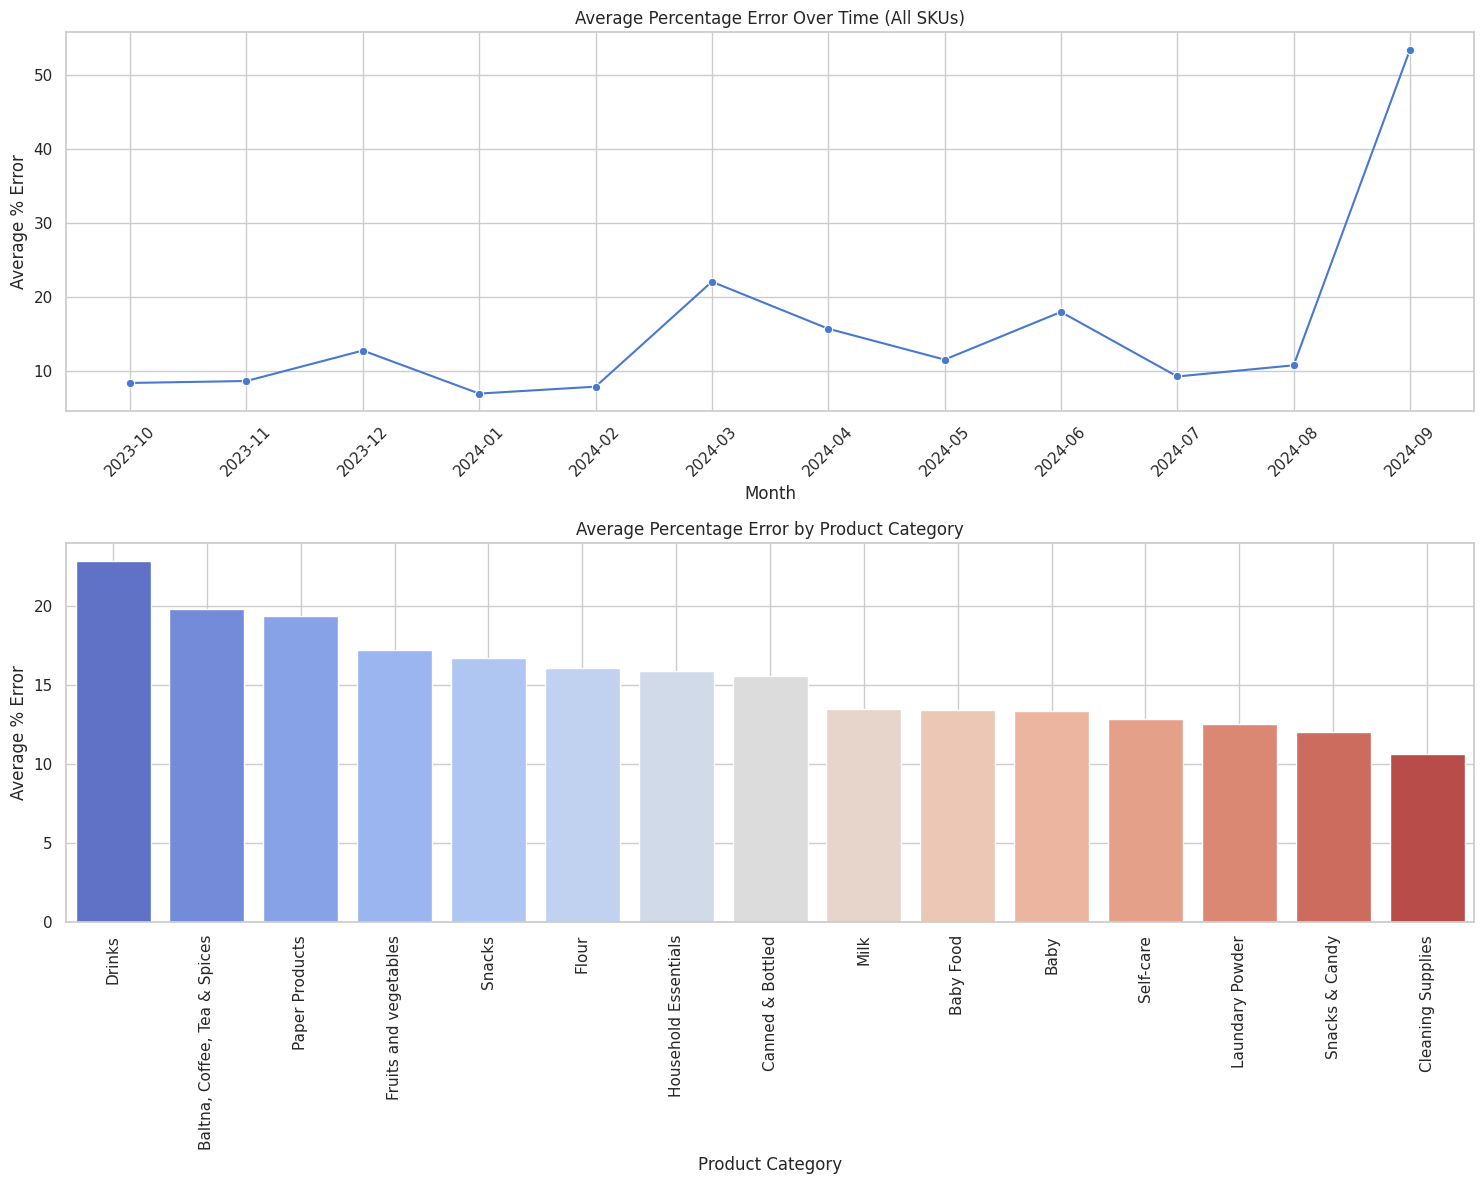

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure results_df is loaded (from previous steps)
if 'results_df' not in locals():
    results_df = pd.read_csv("/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/global_monthly_predictions_per_sku.csv")
    results_df['year_month'] = pd.PeriodIndex(results_df['year_month'], freq='M')

# Also need test_df to get category information for each sku
if 'test_df' not in locals():
    DATA_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/"
    test_df = pd.read_csv(DATA_PATH + "test_data.csv",  parse_dates=["date"])
    test_df = test_df.sort_values(["sku_id", "date"])


plt.style.use('seaborn-v0_8-muted')

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# --- 1. Error Over Time (Aggregated) ---
monthly_avg_error = results_df.groupby('year_month')['pct_error'].mean().reset_index()
sns.lineplot(ax=axes[0], x=monthly_avg_error['year_month'].astype(str), y='pct_error', data=monthly_avg_error, marker='o')
axes[0].set_title('Average Percentage Error Over Time (All SKUs)')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average % Error')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# --- 2. Error by Product Category ---
# Merge results with test_df to get category information for each SKU
sku_to_category = test_df[['sku_id', 'category']].drop_duplicates()
error_by_category = results_df.groupby('sku_id')['pct_error'].mean().reset_index()
error_by_category = error_by_category.merge(sku_to_category, on='sku_id', how='left')

category_avg_error = error_by_category.groupby('category')['pct_error'].mean().sort_values(ascending=False).reset_index()
sns.barplot(ax=axes[1], x='category', y='pct_error', data=category_avg_error, palette='coolwarm')
axes[1].set_title('Average Percentage Error by Product Category')
axes[1].set_xlabel('Product Category')
axes[1].set_ylabel('Average % Error')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(True)

plt.tight_layout()
plt.savefig("additional_error_analysis.png")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import joblib
from tqdm.auto import tqdm
import os

# ----------------------------
# Re-load train_df for consistency with global model feature engineering
# ----------------------------
train_df_for_features = pd.read_csv(
    "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/train_data.csv",
    parse_dates=["date"]
)
train_df_for_features = train_df_for_features.sort_values(["sku_id", "date"])

# ----------------------------
# CONFIG
# ----------------------------
TARGET = "target_qty"
MIN_HISTORY_DAYS = 90 # Not directly used for filtering in this cell, but good to keep consistent

# ----------------------------
# Model and Data Paths
# ----------------------------
MODEL_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/models/"
DATA_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/"

model = joblib.load(
    MODEL_PATH + "global_demand_model.joblib" # Ensure correct global model name
)

# Re-load daily to ensure clean slate for feature engineering
daily = pd.read_csv(
    DATA_PATH + "train_data.csv", # Assuming daily is the training data to forecast from
    parse_dates=["date"]
)
daily = daily.sort_values(["sku_id", "date"])

# ----------------------------
# Helper functions for holiday/fasting
# Fasting
fasting = pd.read_csv(
    "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/raw/fasting_periods.csv"
)
fasting["start_date"] = pd.to_datetime(fasting["start_date"])
fasting["end_date"] = pd.to_datetime(fasting["end_date"])

# Holidays
events = pd.read_csv(
    "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/raw/ethiopian_events.csv"
)
events["date"] = pd.to_datetime(events["date"])

holiday_dates = events[events["is_holiday"] == 1]["date"].sort_values()

def is_fasting_day(d):
    return int(((fasting["start_date"] <= d) & (fasting["end_date"] >= d)).any())

def is_holiday_day(d):
    return int(d in set(holiday_dates))

def days_to_next_holiday(d):
    future = holiday_dates[holiday_dates >= d]
    return (future.iloc[0] - d).days if len(future) else np.nan

def days_since_last_holiday(d):
    past = holiday_dates[holiday_dates <= d]
    return (d - past.iloc[-1]).days if len(past) else np.nan

# ----------------------------
# Feature Engineering for `daily` (consistent with Mv_jgUlwXkQp)
# ----------------------------
# CATEGORY TARGET ENCODING
category_mean = (
    train_df_for_features # Use the re-loaded train_df for feature calculation
    .groupby("category")[TARGET]
    .mean()
)
daily["category_te"] = daily["category"].map(category_mean)

global_mean = train_df_for_features[TARGET].mean()
daily["category_te"] = daily["category_te"].fillna(global_mean)

# SKU BEHAVIOR FEATURES (ROLLING)
def add_sku_behavior_for_daily(df):
    df = df.copy()
    df["sku_avg_28d"] = (
        df.groupby("sku_id")["daily_qty"]
        .rolling(28)
        .mean()
        .reset_index(level=0, drop=True)
    )
    df["sku_std_28d"] = (
        df.groupby("sku_id")["daily_qty"]
        .rolling(28)
        .std()
        .reset_index(level=0, drop=True)
    )
    return df

daily = add_sku_behavior_for_daily(daily)

# ----------------------------
# FINAL FEATURES LIST (Updated to include new features)
# ----------------------------
FEATURES_BASE = [
    "day_of_week",
    "is_weekend",
    "day_of_year",
    "qty_lag_1",
    "qty_lag_7",
    "qty_lag_14",
    "qty_roll_7",
    "qty_roll_14",
    "is_holiday",
    "days_to_holiday",
    "days_since_holiday",
    "is_fasting"
]

FEATURES = FEATURES_BASE + [
    "category_te",
    "sku_avg_28d",
    "sku_std_28d",
]

# ----------------------------
# DROP NA (Only after features ready) - Essential for features involving rolling means/stds
# ----------------------------
daily = daily.dropna(subset=FEATURES + [TARGET])

# Start prediction
FORECAST_DAYS = 90  # ~3 months

all_daily_preds = []

for sku in tqdm(daily["sku_id"].unique(), desc="Rolling forward"):
    sku_hist = daily[daily["sku_id"] == sku].copy()
    sku_hist = sku_hist.sort_values("date")

    if len(sku_hist) < 30: # Keeping original 30 from the cell
        continue

    history_qty = sku_hist[TARGET].tolist()
    last_date = sku_hist["date"].max()
    sku_category_te = sku_hist["category_te"].iloc[-1] # category_te is constant for a SKU

    for step in range(FORECAST_DAYS):
        next_date = last_date + pd.Timedelta(days=1)

        row = {
            "day_of_week": next_date.weekday(),
            "is_weekend": int(next_date.weekday() >= 5),
            "day_of_year": next_date.dayofyear,
            "is_holiday": is_holiday_day(next_date),
            "days_to_holiday": days_to_next_holiday(next_date),
            "days_since_holiday": days_since_last_holiday(next_date),
            "is_fasting": is_fasting_day(next_date),
            "category_te": sku_category_te # Add category_te to the row
        }

        # Lag & rolling features - based on history_qty (actuals + predictions)
        row["qty_lag_1"] = history_qty[-1]
        row["qty_lag_7"] = history_qty[-7] if len(history_qty) >= 7 else history_qty[-1]
        row["qty_lag_14"] = history_qty[-14] if len(history_qty) >= 14 else history_qty[-1]

        row["qty_roll_7"] = np.mean(history_qty[-7:])
        row["qty_roll_14"] = np.mean(history_qty[-14:])

        # Calculate sku_avg_28d and sku_std_28d dynamically for forecast steps
        rolling_window_28 = 28
        if len(history_qty) >= rolling_window_28:
            row["sku_avg_28d"] = np.mean(history_qty[-rolling_window_28:])
            row["sku_std_28d"] = np.std(history_qty[-rolling_window_28:])
        elif len(history_qty) > 0: # If history is present but less than rolling_window_28
            row["sku_avg_28d"] = np.mean(history_qty)
            row["sku_std_28d"] = np.std(history_qty)
        else: # Fallback if history is completely empty (should not be reached if len(sku_hist) < 30 check is robust)
            row["sku_avg_28d"] = 0.0
            row["sku_std_28d"] = 0.0

        # If std is 0 (e.g., all values are same), set to small epsilon to avoid potential issues if std is used as a denominator
        if row["sku_std_28d"] == 0:
            row["sku_std_28d"] = 1e-6

        X = pd.DataFrame([row])[FEATURES]

        y_pred = max(0, round(model.predict(X)[0]))

        all_daily_preds.append({
            "sku_id": sku,
            "date": next_date,
            "predicted_qty": y_pred
        })

        history_qty.append(y_pred)
        last_date = next_date

# Aggregate to monthly
daily_pred_df = pd.DataFrame(all_daily_preds)
daily_pred_df["year_month"] = daily_pred_df["date"].dt.to_period("M")

monthly_pred_df = (
    daily_pred_df
    .groupby(["sku_id", "year_month"])["predicted_qty"]
    .sum()
    .reset_index()
)

# Saving outputs
daily_pred_df.to_csv(
    DATA_PATH + "rolling_daily_forecast.csv",
    index=False
)

monthly_pred_df.to_csv(
    DATA_PATH + "rolling_monthly_forecast.csv",
    index=False
)

print("Rolling-forward forecasting completed.")

Rolling forward:   0%|          | 0/513 [00:00<?, ?it/s]

Rolling-forward forecasting completed.


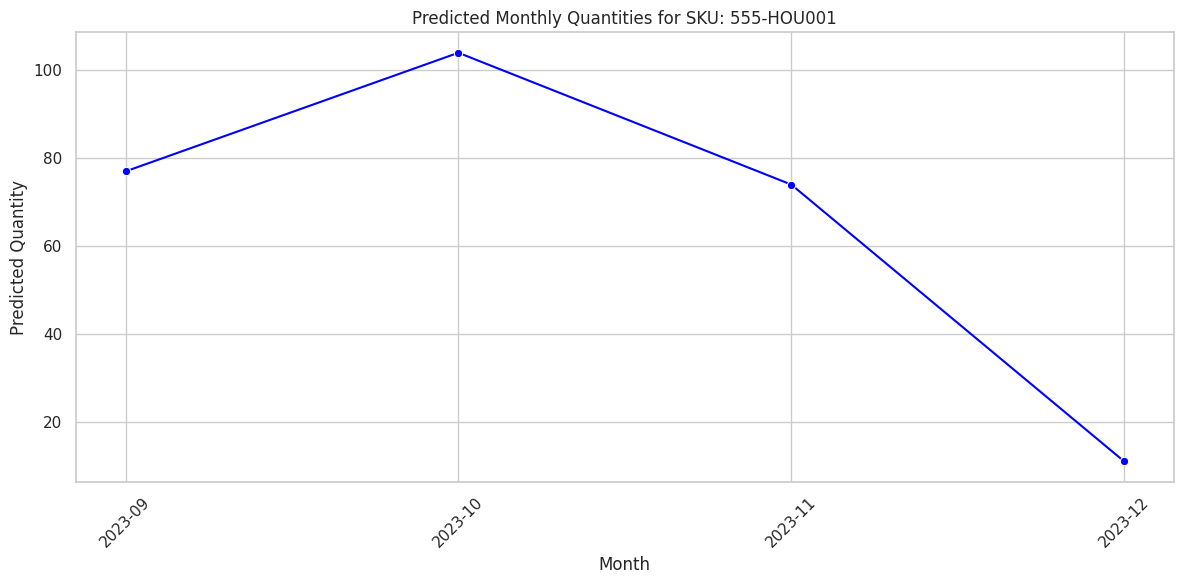

Displaying monthly forecast for sample SKU: 555-HOU001


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/"
forecast_df = pd.read_csv(DATA_PATH + "rolling_monthly_forecast.csv")
forecast_df['year_month'] = pd.PeriodIndex(forecast_df['year_month'], freq='M')

# Select a sample SKU (e.g., the first one in the forecast)
sample_sku_forecast = forecast_df['sku_id'].iloc[0]
sample_forecast_results = forecast_df[forecast_df['sku_id'] == sample_sku_forecast].sort_values('year_month')

plt.figure(figsize=(12, 6))
sns.lineplot(x=sample_forecast_results['year_month'].astype(str), y='predicted_qty', data=sample_forecast_results, marker='o', color='blue')

plt.title(f'Predicted Monthly Quantities for SKU: {sample_sku_forecast}')
plt.xlabel('Month')
plt.ylabel('Predicted Quantity')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Displaying monthly forecast for sample SKU: {sample_sku_forecast}")

Rolling-Forward Overall Mean Absolute Error: 57.30
Rolling-Forward Overall Mean Absolute Percentage Error: 42.39%


/tmp/ipython-input-2237467956.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right') # Rotate and align labels


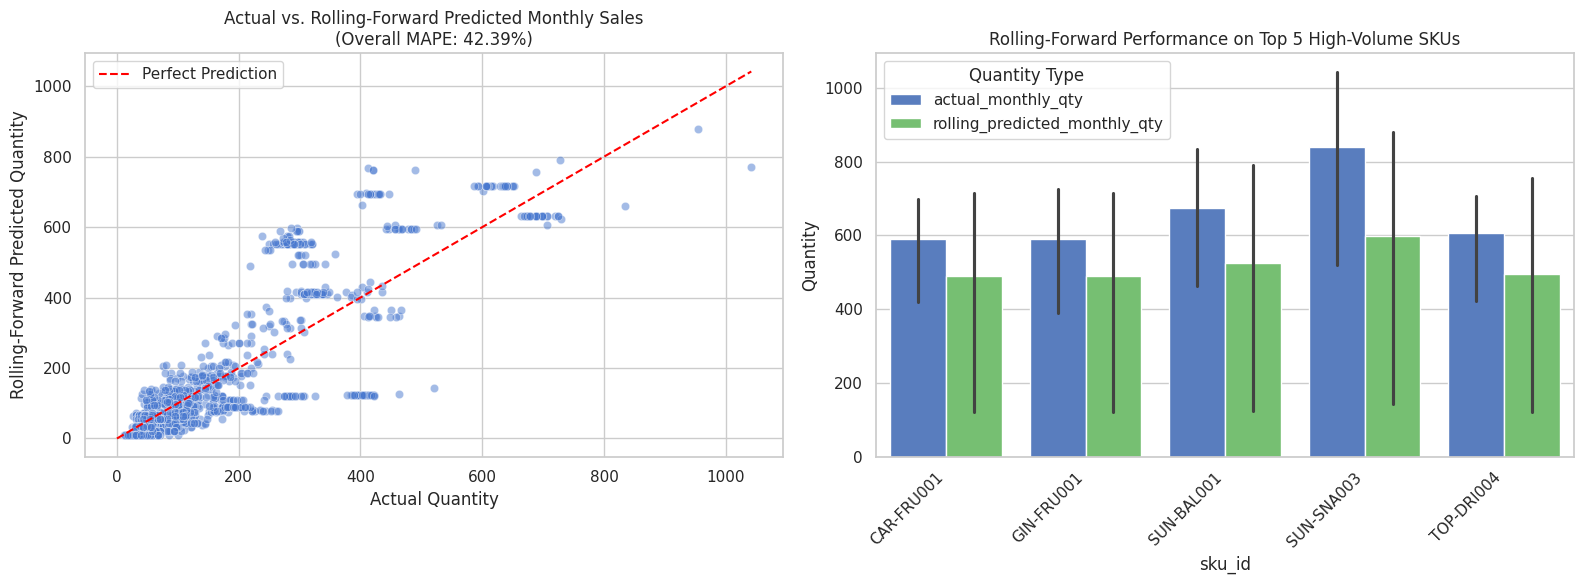

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/"

# Load rolling-forward predictions
rolling_preds_df = pd.read_csv(DATA_PATH + "rolling_monthly_forecast.csv")
rolling_preds_df['year_month'] = pd.PeriodIndex(rolling_preds_df['year_month'], freq='M')
rolling_preds_df = rolling_preds_df.rename(columns={'predicted_qty': 'rolling_predicted_monthly_qty'})

# Load actuals (and initial model predictions for comparison, if needed, but focus on actuals here)
actual_df = pd.read_csv(DATA_PATH + "global_monthly_predictions_per_sku.csv")
actual_df['year_month'] = pd.PeriodIndex(actual_df['year_month'], freq='M')

# Merge the two dataframes to compare rolling-forward predictions with actuals
comparison_df = pd.merge(
    actual_df[['sku_id', 'year_month', 'actual_monthly_qty']],
    rolling_preds_df,
    on=['sku_id', 'year_month'],
    how='inner' # Ensure we only compare for common SKU-month pairs
)

# Calculate error metrics for the rolling-forward predictions
comparison_df['rolling_abs_error'] = (
    comparison_df['rolling_predicted_monthly_qty'] - comparison_df['actual_monthly_qty']
).abs()
comparison_df['rolling_pct_error'] = np.where(
    comparison_df['actual_monthly_qty'] > 0,
    comparison_df['rolling_abs_error'] / comparison_df['actual_monthly_qty'] * 100,
    0
)

# Calculate Global Metrics for the rolling-forward model
overall_mae_rolling = comparison_df['rolling_abs_error'].mean()
overall_mape_rolling = comparison_df['rolling_pct_error'].mean()

print(f"Rolling-Forward Overall Mean Absolute Error: {overall_mae_rolling:.2f}")
print(f"Rolling-Forward Overall Mean Absolute Percentage Error: {overall_mape_rolling:.2f}%")

# Plotting Setup
plt.style.use('seaborn-v0_8-muted')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- PLOT 1: Scatter Plot (Actual vs Rolling-Forward Predicted) ---
sns.scatterplot(
    data=comparison_df,
    x='actual_monthly_qty',
    y='rolling_predicted_monthly_qty',
    alpha=0.5,
    ax=ax1
)
# Add a 45-degree line (Perfect prediction line)
max_val = max(
    comparison_df['actual_monthly_qty'].max(),
    comparison_df['rolling_predicted_monthly_qty'].max()
)
ax1.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Prediction')

ax1.set_title(f"Actual vs. Rolling-Forward Predicted Monthly Sales\n(Overall MAPE: {overall_mape_rolling:.2f}%)")
ax1.set_xlabel("Actual Quantity")
ax1.set_ylabel("Rolling-Forward Predicted Quantity")
ax1.legend()

# --- PLOT 2: Top 5 SKUs Comparison (Rolling-Forward) ---
# Get the top 5 SKUs by total actual volume for the comparison period
top_skus_rolling = comparison_df.groupby('sku_id')['actual_monthly_qty'].sum().nlargest(5).index
top_df_rolling = comparison_df[comparison_df['sku_id'].isin(top_skus_rolling)]

# Melt the data for easier plotting with Seaborn
melted_df_rolling = top_df_rolling.melt(
    id_vars=['sku_id', 'year_month'],
    value_vars=['actual_monthly_qty', 'rolling_predicted_monthly_qty'],
    var_name='Type',
    value_name='Quantity'
)

sns.barplot(data=melted_df_rolling, x='sku_id', y='Quantity', hue='Type', ax=ax2)
ax2.set_title("Rolling-Forward Performance on Top 5 High-Volume SKUs")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right') # Rotate and align labels
ax2.legend(title='Quantity Type')

plt.tight_layout()
plt.savefig("rolling_forward_performance.png")
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# ----------------------------
# PATHS
# ----------------------------
TEST_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/test_data.csv"
ROLLING_DAILY_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/rolling_daily_forecast.csv"

# ----------------------------
# LOAD
# ----------------------------
test_df = pd.read_csv(TEST_PATH, parse_dates=["date"])
rolling_daily = pd.read_csv(ROLLING_DAILY_PATH, parse_dates=["date"])

# Keep only what we need
test_daily = test_df[["sku_id", "date", "target_qty"]].copy()

# ----------------------------
# MERGE
# ----------------------------
daily_compare = (
    rolling_daily
    .merge(
        test_daily,
        on=["sku_id", "date"],
        how="inner"
    )
)

# ----------------------------
# ERRORS
# ----------------------------
daily_compare["abs_error"] = np.abs(
    daily_compare["target_qty"] - daily_compare["predicted_qty"]
)

daily_compare["pct_error"] = (
    daily_compare["abs_error"] /
    np.maximum(daily_compare["target_qty"], 1)
) * 100

# ----------------------------
# METRICS
# ----------------------------
daily_mae = daily_compare["abs_error"].mean()
daily_wape = (
    daily_compare["abs_error"].sum() /
    daily_compare["target_qty"].sum()
) * 100

print("===== DAILY ROLLING vs ACTUAL =====")
print(f"MAE  : {daily_mae:.2f}")
print(f"WAPE : {daily_wape:.2f}%")

# ----------------------------
# SAVE
# ----------------------------
daily_compare.to_csv(
    "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/rolling_daily_vs_actual.csv",
    index=False
)

print("Saved: rolling_daily_vs_actual.csv")


===== DAILY ROLLING vs ACTUAL =====
MAE  : 2.84
WAPE : 42.04%
Saved: rolling_daily_vs_actual.csv


In [ ]:
# ----------------------------
# MONTHLY ACTUAL
# ----------------------------
test_df["year_month"] = test_df["date"].dt.to_period("M")

actual_monthly = (
    test_df
    .groupby(["sku_id", "year_month"])
    .agg(actual_qty=("target_qty", "sum"))
    .reset_index()
)

# ----------------------------
# LOAD ROLLING MONTHLY
# ----------------------------
rolling_monthly = pd.read_csv(
    "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/rolling_monthly_forecast.csv"
)

rolling_monthly["year_month"] = rolling_monthly["year_month"].astype("period[M]")

# ----------------------------
# MERGE
# ----------------------------
monthly_compare = (
    rolling_monthly
    .merge(
        actual_monthly,
        on=["sku_id", "year_month"],
        how="inner"
    )
)

# ----------------------------
# ERRORS
# ----------------------------
monthly_compare["abs_error"] = np.abs(
    monthly_compare["actual_qty"] - monthly_compare["predicted_qty"]
)

monthly_compare["pct_error"] = (
    monthly_compare["abs_error"] /
    np.maximum(monthly_compare["actual_qty"], 1)
) * 100

# ----------------------------
# METRICS
# ----------------------------
monthly_mae = monthly_compare["abs_error"].mean()
monthly_wape = (
    monthly_compare["abs_error"].sum() /
    monthly_compare["actual_qty"].sum()
) * 100

print("\n===== MONTHLY ROLLING vs ACTUAL =====")
print(f"MAE  : {monthly_mae:.2f}")
print(f"WAPE : {monthly_wape:.2f}%")

# ----------------------------
# SAVE
# ----------------------------
monthly_compare.to_csv(
    "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/rolling_monthly_vs_actual.csv",
    index=False
)

print("Saved: rolling_monthly_vs_actual.csv")



===== MONTHLY ROLLING vs ACTUAL =====
MAE  : 50.06
WAPE : 29.50%
Saved: rolling_monthly_vs_actual.csv


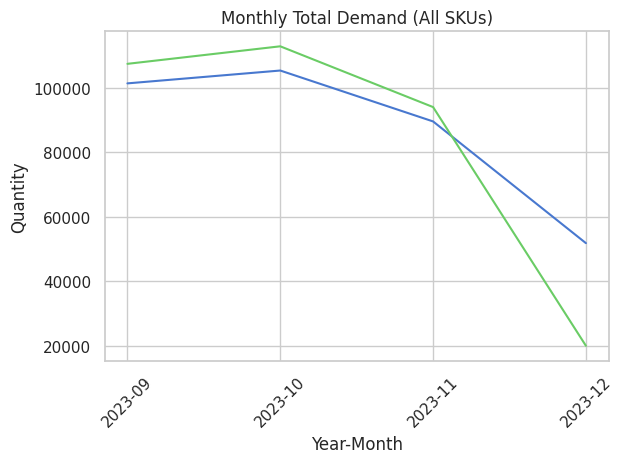

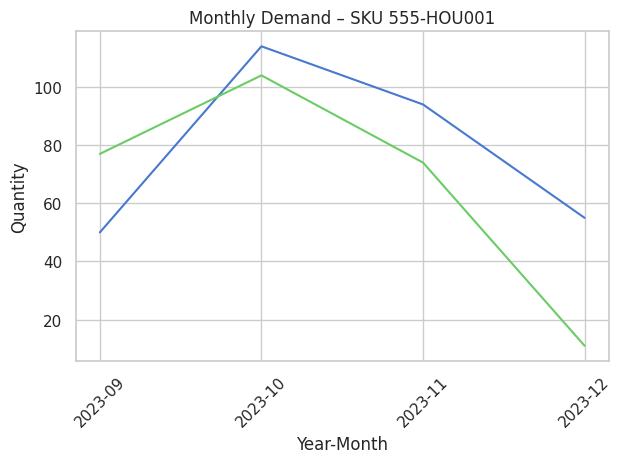

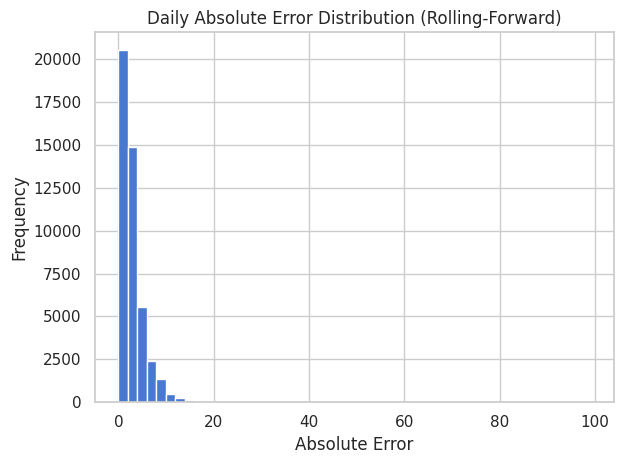

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# FIX THESE TWO PATHS ONLY
# ============================
DAILY_COMPARE_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/rolling_daily_vs_actual.csv"
MONTHLY_COMPARE_PATH = "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/rolling_monthly_vs_actual.csv"

# ----------------------------
# LOAD DATA
# ----------------------------
daily_df = pd.read_csv(DAILY_COMPARE_PATH, parse_dates=["date"])
monthly_df = pd.read_csv(MONTHLY_COMPARE_PATH)

# ----------------------------
# 1) MONTHLY TOTAL (ALL SKUs)
# ----------------------------
monthly_total = (
    monthly_df
    .groupby("year_month")[["actual_qty", "predicted_qty"]]
    .sum()
    .reset_index()
)

monthly_total["year_month"] = monthly_total["year_month"].astype(str)

plt.figure()
plt.plot(monthly_total["year_month"], monthly_total["actual_qty"])
plt.plot(monthly_total["year_month"], monthly_total["predicted_qty"])
plt.xticks(rotation=45)
plt.title("Monthly Total Demand (All SKUs)")
plt.xlabel("Year-Month")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()

# ----------------------------
# 2) SINGLE SKU MONTHLY VIEW
# ----------------------------
example_sku = monthly_df["sku_id"].iloc[0]

sku_monthly = monthly_df[monthly_df["sku_id"] == example_sku].copy()
sku_monthly["year_month"] = sku_monthly["year_month"].astype(str)

plt.figure()
plt.plot(sku_monthly["year_month"], sku_monthly["actual_qty"])
plt.plot(sku_monthly["year_month"], sku_monthly["predicted_qty"])
plt.xticks(rotation=45)
plt.title(f"Monthly Demand – SKU {example_sku}")
plt.xlabel("Year-Month")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()

# ----------------------------
# 3) DAILY ERROR DISTRIBUTION
# ----------------------------
plt.figure()
plt.hist(daily_df["abs_error"], bins=50)
plt.title("Daily Absolute Error Distribution (Rolling-Forward)")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


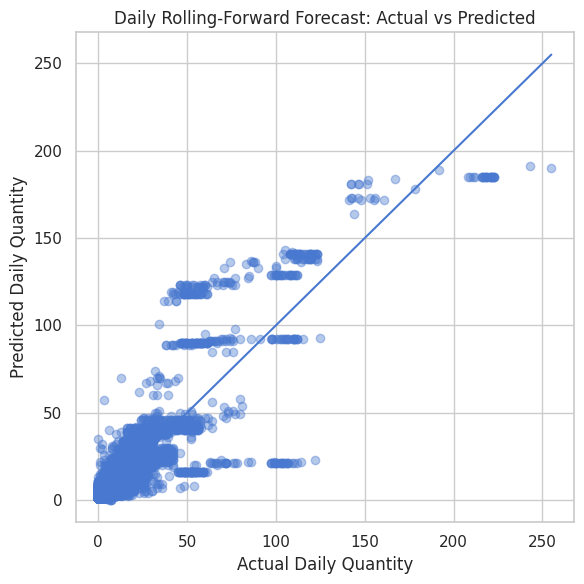

In [ ]:
# Daily scatter plot
import pandas as pd
import matplotlib.pyplot as plt

# Load comparison file (adjust path if needed)
daily = pd.read_csv(
    "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/rolling_daily_vs_actual.csv"
)

plt.figure(figsize=(6, 6))
plt.scatter(
    daily["target_qty"],
    daily["predicted_qty"],
    alpha=0.4
)

# 45-degree reference line (perfect predictions)
max_val = max(daily["target_qty"].max(), daily["predicted_qty"].max())
plt.plot([0, max_val], [0, max_val])

plt.xlabel("Actual Daily Quantity")
plt.ylabel("Predicted Daily Quantity")
plt.title("Daily Rolling-Forward Forecast: Actual vs Predicted")
plt.tight_layout()
plt.show()

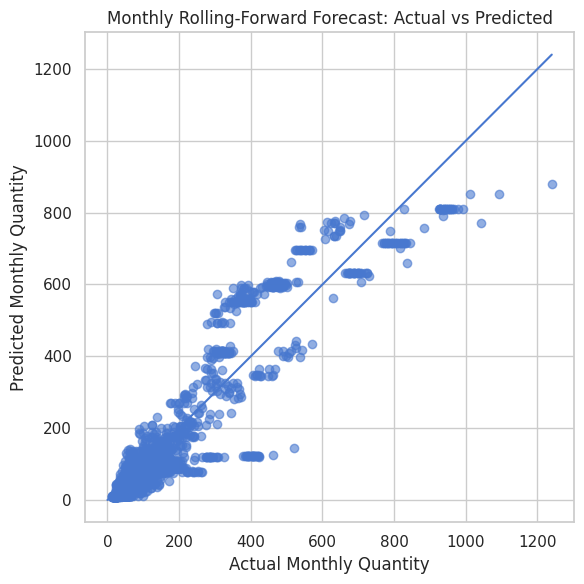

In [ ]:
# Monthly scatter plot
monthly = pd.read_csv(
    "/content/drive/MyDrive/ML Projects/Sales_Forecasting_Project/data/processed/rolling_monthly_vs_actual.csv"
)

plt.figure(figsize=(6, 6))
plt.scatter(
    monthly["actual_qty"],
    monthly["predicted_qty"],
    alpha=0.6
)

max_val = max(monthly["actual_qty"].max(), monthly["predicted_qty"].max())
plt.plot([0, max_val], [0, max_val])

plt.xlabel("Actual Monthly Quantity")
plt.ylabel("Predicted Monthly Quantity")
plt.title("Monthly Rolling-Forward Forecast: Actual vs Predicted")
plt.tight_layout()
plt.show()

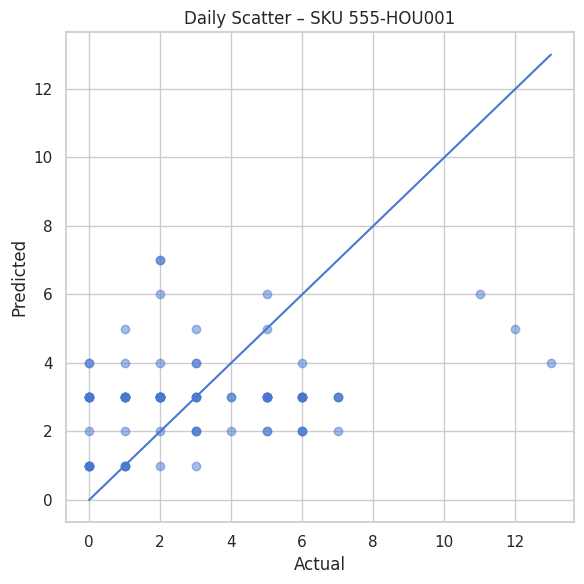

In [ ]:
# Per SKU scatter plot
sku_id = daily["sku_id"].iloc[0]  # pick any SKU you want

sku_daily = daily[daily["sku_id"] == sku_id]

plt.figure(figsize=(6, 6))
plt.scatter(
    sku_daily["target_qty"],
    sku_daily["predicted_qty"],
    alpha=0.5
)

max_val = max(sku_daily["target_qty"].max(), sku_daily["predicted_qty"].max())
plt.plot([0, max_val], [0, max_val])

plt.title(f"Daily Scatter – SKU {sku_id}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()
